# Instructions for Project3 demo
Here, we use python to create a testbench to evaluate our HLS core. We also provide two examples for streaming and simple interrupt control. You have to use them to complete a host program and evaluate your design with interrupts.

# Start with software DFT to generate our signals

## Import required libraries 

In [1]:
import time
from pynq import Overlay
import pynq.lib.dma
from pynq import Xlnk
import numpy as np
import asyncio
from psutil import cpu_percent
import matplotlib.pyplot as plt
import scipy.signal as signal

## DFT size, number of signals, and arrays to hold input, software output, and hardware output

In [2]:
sw_dft = np.fft.fft # software DFT
length = 1024 # this is our DFT size
no_signals = 4 # number of test signals
all_inps = np.empty([length*no_signals,], dtype=np.complex) # we will use it as input to our HLS core
all_outs_sw = np.empty([length*no_signals,], dtype=np.complex) # this is our reference to test our design error
all_outs_hw = np.empty([length*no_signals,], dtype=np.complex) # output of HLS will be saved in this array

## sig_0: a simple sinusoidal complex signal with four frequencies

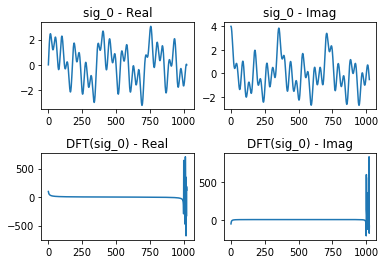

In [3]:
sig_0 = np.sin(np.arange(length) * np.pi / 180. ) + 1j* np.cos(np.arange(length) * np.pi / 180. ) \
    +   np.sin(np.arange(length) * np.pi / 90. ) + 1j* np.cos(np.arange(length) * np.pi / 90. ) \
    +   np.sin(np.arange(length) * np.pi / 45. ) + 1j* np.cos(np.arange(length) * np.pi / 45. ) \
    +   np.sin(np.arange(length) * np.pi / 22. ) + 1j* np.cos(np.arange(length) * np.pi / 22. )

dft_sig_0 = sw_dft(sig_0, length) # calculating DFT in software
all_inps[length*0:length*(0+1)] = sig_0 # copy siq_0 to input array
all_outs_sw[length*0:length*(0+1)] = dft_sig_0 # copy sw_dft(sig_0) to sw_output array
    
# ploting inp and out signals for sig_0
f, ((plt1, plt2), (plt3, plt4)) = plt.subplots(2, 2)
plt1.plot(sig_0.real)
plt1.set_title('sig_0 - Real')

plt2.plot(sig_0.imag)
plt2.set_title('sig_0 - Imag')

plt3.plot(dft_sig_0.real)
plt3.set_title('DFT(sig_0) - Real')

plt4.plot(dft_sig_0.imag)
plt4.set_title('DFT(sig_0) - Imag')
plt.subplots_adjust(hspace=0.5)

## sig_1: a complex chirp signal

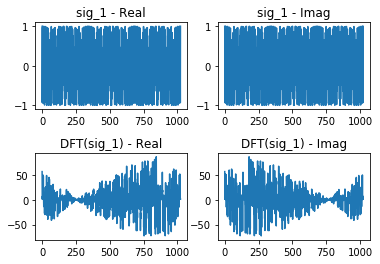

In [4]:
sig_1 = signal.chirp(np.arange(length), 100, length-1, 1e3) \
      + 1j* signal.chirp(np.arange(length), 1e3, length-1, 100)

dft_sig_1 = sw_dft(sig_1, length) # calculating DFT in software
all_inps[length*1:length*(1+1)] = sig_1 # copy siq_1 to input array
all_outs_sw[length*1:length*(1+1)] = dft_sig_1 # copy sw_dft(sig_1) to sw_output array

# ploting inp and out signals for sig_1
f, ((plt1, plt2), (plt3, plt4)) = plt.subplots(2, 2)
plt1.plot(sig_1.real)
plt1.set_title('sig_1 - Real')

plt2.plot(sig_1.imag)
plt2.set_title('sig_1 - Imag')

plt3.plot(dft_sig_1.real)
plt3.set_title('DFT(sig_1) - Real')

plt4.plot(dft_sig_1.imag)
plt4.set_title('DFT(sig_1) - Imag')
plt.subplots_adjust(hspace=0.5)

## sig_2: a complex sawtooth signal

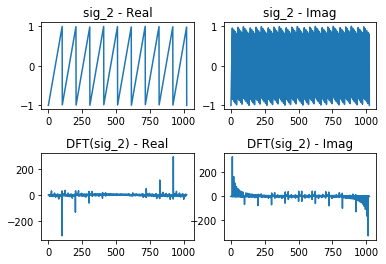

In [5]:
sig_2 = signal.sawtooth(2 * np.pi * 10 * np.linspace(0, 1, length) ) \
      + 1j* signal.sawtooth(2 * np.pi * 100 * np.linspace(0, 1, length) )
    
dft_sig_2 = sw_dft(sig_2, length) # calculating DFT in software
all_inps[length*2:length*(2+1)] = sig_2 # copy siq_2 to input array
all_outs_sw[length*2:length*(2+1)] = dft_sig_2 # copy sw_dft(sig_2) to sw_output array

# ploting inp and out signals for sig_2
f, ((plt1, plt2), (plt3, plt4)) = plt.subplots(2, 2)
plt1.plot(sig_2.real)
plt1.set_title('sig_2 - Real')

plt2.plot(sig_2.imag)
plt2.set_title('sig_2 - Imag')

plt3.plot(dft_sig_2.real)
plt3.set_title('DFT(sig_2) - Real')

plt4.plot(dft_sig_2.imag)
plt4.set_title('DFT(sig_2) - Imag')
plt.subplots_adjust(hspace=0.5)

## sig_3: a random complex signal (noise)

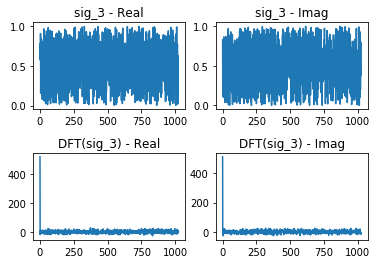

In [6]:
sig_3 = np.random.rand(length) + 1j*np.random.rand(length)

dft_sig_3 = sw_dft(sig_3, length) # calculating DFT in software
all_inps[length*3:length*(3+1)] = sig_3 # copy siq_3 to input array
all_outs_sw[length*3:length*(3+1)] = dft_sig_3 # copy sw_dft(sig_3) to sw_output array

# ploting inp and out signals for sig_3
f, ((plt1, plt2), (plt3, plt4)) = plt.subplots(2, 2)
plt1.plot(sig_3.real)
plt1.set_title('sig_3 - Real')

plt2.plot(sig_3.imag)
plt2.set_title('sig_3 - Imag')

plt3.plot(dft_sig_3.real)
plt3.set_title('DFT(sig_3) - Real')

plt4.plot(dft_sig_3.imag)
plt4.set_title('DFT(sig_3) - Imag')
plt.subplots_adjust(hspace=0.5)

# Using our input signals, we evaluate our HLS core
In this section, we go through two examples for simple interrupt control and streaming. You have to use these two examples to complete your final host program.

## Example 1: Factorial Interrupt Controller

In [7]:
# HLS register addresses
IP_CTRL = 0x00
AP_START = 0x1
GIER = 0x04
IP_IER = 0x08
IP_ISR = 0x0C
INTRPT_AP_DONE = 0x1
INTRPT_AP_READY = 0x2
OUT_REG = 0x10
INP_REG = 0x18

ol = Overlay('fact_intrpt.bit') # load bitstream
t_before_bitstream = time.time()
ol.download() # download bitstream to FPGA
t_after_bitstream = time.time()
print(t_after_bitstream - t_before_bitstream, 'seconds to program bitstream')

fact_ip = ol.fact_intrpt # HLS core
fact_ip.write(GIER, 0x1) # enable interrupts
fact_ip.write(IP_IER, INTRPT_AP_READY|INTRPT_AP_DONE) # enable both interrupts

no_runs = 10
# Coroutine to service the interrupts
async def service_interrupts(ip):
    factorial_input = 1 # first input
    print('Calling fact({})'.format(factorial_input))
    ip.write(INP_REG, factorial_input) # write the input
    ip.write(IP_CTRL, AP_START) # start the core
    
    i=0 # for counting our reads
    j=1 # for counting our writes. We already sent one input so we start from 1
    while i<no_runs or j<no_runs: # we like to read exactly no_runs times and write one less
        await ip.interrupt.wait() # Wait for an interrupt
        if (ip.read(IP_ISR) & INTRPT_AP_DONE): # got an ap_done interrupt
            ip.write(IP_ISR, INTRPT_AP_DONE) # clear ap_done interrupt
            if i<no_runs:
                print('interrupt received AP_DONE.\nThe result is {}\n\n'.format(ip.read(OUT_REG))) # print output
                i += 1
        elif (ip.read(IP_ISR) & INTRPT_AP_READY): # got an ap_ready interrupt
            ip.write(IP_ISR, INTRPT_AP_READY) # clear the ap_ready interrupt
            if j<no_runs:
                factorial_input += 1
                print('interrupt received AP_READY.\nCalling fact({})'.format(factorial_input))
                fact_ip.write(INP_REG, factorial_input) # write the input
                fact_ip.write(IP_CTRL, AP_START) # start the core
                j += 1
            

cpu_percent(percpu=True)  # Initializing the CPU monitoring.
asyncio.get_event_loop().run_until_complete(service_interrupts(fact_ip))
cpu_used = cpu_percent(percpu=True)

# Printing the CPU utilization
print('CPU Utilization = {cpu_used}'.format(**locals()))

0.8100447654724121 seconds to program bitstream
Calling fact(1)
interrupt received AP_DONE.
The result is 1


interrupt received AP_READY.
Calling fact(2)
interrupt received AP_DONE.
The result is 2


interrupt received AP_READY.
Calling fact(3)
interrupt received AP_DONE.
The result is 6


interrupt received AP_READY.
Calling fact(4)
interrupt received AP_DONE.
The result is 24


interrupt received AP_READY.
Calling fact(5)
interrupt received AP_DONE.
The result is 120


interrupt received AP_READY.
Calling fact(6)
interrupt received AP_DONE.
The result is 720


interrupt received AP_READY.
Calling fact(7)
interrupt received AP_DONE.
The result is 5040


interrupt received AP_READY.
Calling fact(8)
interrupt received AP_DONE.
The result is 40320


interrupt received AP_READY.
Calling fact(9)
interrupt received AP_DONE.
The result is 362880


interrupt received AP_READY.
Calling fact(10)
interrupt received AP_DONE.
The result is 3628800


CPU Utilization = [80.0, 33.3]


# Important:
Run the following cells after moving your .bit and .tcl files to this directory

## Example 2: running DFT HLS core with no interrupts
This part runs your core without interrupts

In [8]:
# HLS register addresses
IP_CTRL = 0x00
AP_START = 0x1
GIER = 0x04
IP_IER = 0x08
IP_ISR = 0x0C
INTRPT_AP_DONE = 0x1
INTRPT_AP_READY = 0x2

ol = Overlay('dft.bit') # load bitstream - check against your bitstream name and location
t_before_bitstream = time.time()
ol.download() # download bitstream to FPGA
print(ol.ip_dict)  # print overlay contents
t_after_bitstream = time.time()
print(t_after_bitstream - t_before_bitstream, 'seconds to program bitstream')

dmaII = ol.axi_dma_1 # first dma. Connected to inpI and outI
dmaRR = ol.axi_dma_0 # second dma. Connected to inpR and outR
dft_ip = ol.dft_0 # HLS core
dft_ip.write(GIER, 0x1) # disable interrupts

xlnk = Xlnk()
inp_bufferI = xlnk.cma_array(shape=(length,), dtype=np.float32) # input buffer I
inp_bufferR = xlnk.cma_array(shape=(length,), dtype=np.float32) # input buffer R
out_bufferI = xlnk.cma_array(shape=(length,), dtype=np.float32) # output buffer I
out_bufferR = xlnk.cma_array(shape=(length,), dtype=np.float32) # output buffer R

t_before = time.time()
for i in range(no_signals):
    print('processing sig_{} ...'.format(i))
    np.copyto(inp_bufferI, all_inps[length*i:length*(i+1)].imag) # copy input.imag to input buffer I
    np.copyto(inp_bufferR, all_inps[length*i:length*(i+1)].real) # copy input.real to input buffer R
    
    dmaII.sendchannel.transfer(inp_bufferI) # write input buffer I to dmaII.inp
    dmaRR.sendchannel.transfer(inp_bufferR) # write input buffer R to dmaRR.inp
    dmaII.recvchannel.transfer(out_bufferI) # write dmaII.out to output buffer I
    dmaRR.recvchannel.transfer(out_bufferR) # write dmaRR.out to output buffer R
    dft_ip.write(IP_CTRL, AP_START) # start the core
    dmaII.sendchannel.wait()
    dmaRR.sendchannel.wait()
    dmaII.recvchannel.wait()
    dmaRR.recvchannel.wait()
    
    np.copyto(all_outs_hw[length*i:length*(i+1)].imag, out_bufferI) # copy output buffer I to output.imag
    np.copyto(all_outs_hw[length*i:length*(i+1)].real, out_bufferR) # copy output buffer R to output.real
    print('processing sig_{} is done.'.format(i))    
t_after = time.time()

print('\n{} seconds to run on HW\n'.format(t_after - t_before))

inp_bufferI.close()
inp_bufferR.close()
out_bufferI.close()
out_bufferR.close()

for i in range(no_signals):
    error_I = np.sqrt(np.mean((all_outs_sw[length*i:length*(i+1)].imag - all_outs_hw[length*i:length*(i+1)].imag)**2))
    error_R = np.sqrt(np.mean((all_outs_sw[length*i:length*(i+1)].real - all_outs_hw[length*i:length*(i+1)].real)**2))
    print('sig_{}: Imag error={}, Real error={}\n'.format(i, error_I, error_R))

{'axi_dma_0': {'phys_addr': 1077936128, 'addr_range': 65536, 'type': 'xilinx.com:ip:axi_dma:7.1', 'state': None, 'interrupts': {}, 'gpio': {}, 'fullpath': 'axi_dma_0', 'driver': <class 'pynq.lib.dma.DMA'>}, 'axi_dma_1': {'phys_addr': 1078001664, 'addr_range': 65536, 'type': 'xilinx.com:ip:axi_dma:7.1', 'state': None, 'interrupts': {}, 'gpio': {}, 'fullpath': 'axi_dma_1', 'driver': <class 'pynq.lib.dma.DMA'>}, 'axi_intc_0': {'phys_addr': 1098907648, 'addr_range': 65536, 'type': 'xilinx.com:ip:axi_intc:4.1', 'state': None, 'interrupts': {}, 'gpio': {}, 'fullpath': 'axi_intc_0', 'driver': <class 'pynq.overlay.DefaultIP'>}, 'dft_0': {'phys_addr': 1136656384, 'addr_range': 65536, 'type': 'xilinx.com:hls:dft:1.0', 'state': None, 'interrupts': {'interrupt': {'controller': 'axi_intc_0', 'index': 0, 'fullpath': 'dft_0/interrupt'}}, 'gpio': {}, 'fullpath': 'dft_0', 'driver': <class 'pynq.overlay.DefaultIP'>}}
0.41745615005493164 seconds to program bitstream
processing sig_0 ...
processing sig_0 

# Complete the following code

## Running DFT HLS core with interrupts 
In this part, you should write code that will run your DFT HLS IP core using AP_READY and AP_DONE interrupts (as shown in Example 1). You should send and receive the data using DMA (as done in Example 2). In essence, you should combine these two examples into one. 

You can assume that the input data is stored in all_inps. You should put the output data into all_outs_hw. 

In [14]:
# HLS register addresses

# Load bitstream and download it to FPGA

# Enable interrupts

# Allocate buffers

# Copy the first signal to input buffers

# Create a coroutine that services interrupts
# Send your first signal and for the rest, copy the signal to DMA when you receive ap_ready
# and read from DMA when you receive ap_done
        
# Run the event loop            

# Free DMA buffers

# HLS register addresses
IP_CTRL = 0x00
AP_START = 0x1
GIER = 0x04
IP_IER = 0x08
IP_ISR = 0x0C
INTRPT_AP_DONE = 0x1
INTRPT_AP_READY = 0x2

ol = Overlay('dft.bit') # load bitstream - check against your bitstream name and location
t_before_bitstream = time.time()
ol.download() # download bitstream to FPGA
print(ol.ip_dict)  # print overlay contents
t_after_bitstream = time.time()
print(t_after_bitstream - t_before_bitstream, 'seconds to program bitstream')

dmaII = ol.axi_dma_1 # first dma. Connected to inpI and outI
dmaRR = ol.axi_dma_0 # second dma. Connected to inpR and outR
dft_ip = ol.dft_0 # HLS core
dft_ip.write(GIER, 0x0) # enable interrupts
fact_ip.write(IP_IER, INTRPT_AP_READY|INTRPT_AP_DONE) # enable both interrupts

xlnk = Xlnk()
inp_bufferI = xlnk.cma_array(shape=(length,), dtype=np.float32) # input buffer I
inp_bufferR = xlnk.cma_array(shape=(length,), dtype=np.float32) # input buffer R
out_bufferI = xlnk.cma_array(shape=(length,), dtype=np.float32) # output buffer I
out_bufferR = xlnk.cma_array(shape=(length,), dtype=np.float32) # output buffer R

t_before = time.time()
no_runs = 10
# Coroutine for interrupts
async def service_interrupts(ip):
    
    for i in range(no_signals):
        print('processing sig_{} ...'.format(i))
        np.copyto(inp_bufferI, all_inps[length*i:length*(i+1)].imag) # copy input.imag to input buffer I
        np.copyto(inp_bufferR, all_inps[length*i:length*(i+1)].real) # copy input.real to input buffer R

        dmaII.sendchannel.transfer(inp_bufferI) # write input buffer I to dmaII.inp
        dmaRR.sendchannel.transfer(inp_bufferR) # write input buffer R to dmaRR.inp
        dmaII.recvchannel.transfer(out_bufferI) # write dmaII.out to output buffer I
        dmaRR.recvchannel.transfer(out_bufferR) # write dmaRR.out to output buffer R
        dft_ip.write(IP_CTRL, AP_START) # start the core
        dmaII.sendchannel.wait()
        dmaRR.sendchannel.wait()
        dmaII.recvchannel.wait()
        dmaRR.recvchannel.wait()

        np.copyto(all_outs_hw[length*i:length*(i+1)].imag, out_bufferI) # copy output buffer I to output.imag
        np.copyto(all_outs_hw[length*i:length*(i+1)].real, out_bufferR) # copy output buffer R to output.real
        print('processing sig_{} is done.'.format(i)) 
    
    
t_after = time.time()

print('\n{} seconds to run on HW\n'.format(t_after - t_before))

inp_bufferI.close()
inp_bufferR.close()
out_bufferI.close()
out_bufferR.close()

for i in range(no_signals):
    error_I = np.sqrt(np.mean((all_outs_sw[length*i:length*(i+1)].imag - all_outs_hw[length*i:length*(i+1)].imag)**2))
    error_R = np.sqrt(np.mean((all_outs_sw[length*i:length*(i+1)].real - all_outs_hw[length*i:length*(i+1)].real)**2))
    print('sig_{}: Imag error={}, Real error={}\n'.format(i, error_I, error_R))

{'axi_dma_0': {'phys_addr': 1077936128, 'addr_range': 65536, 'type': 'xilinx.com:ip:axi_dma:7.1', 'state': None, 'interrupts': {}, 'gpio': {}, 'fullpath': 'axi_dma_0', 'driver': <class 'pynq.lib.dma.DMA'>}, 'axi_dma_1': {'phys_addr': 1078001664, 'addr_range': 65536, 'type': 'xilinx.com:ip:axi_dma:7.1', 'state': None, 'interrupts': {}, 'gpio': {}, 'fullpath': 'axi_dma_1', 'driver': <class 'pynq.lib.dma.DMA'>}, 'axi_intc_0': {'phys_addr': 1098907648, 'addr_range': 65536, 'type': 'xilinx.com:ip:axi_intc:4.1', 'state': None, 'interrupts': {}, 'gpio': {}, 'fullpath': 'axi_intc_0', 'driver': <class 'pynq.overlay.DefaultIP'>}, 'dft_0': {'phys_addr': 1136656384, 'addr_range': 65536, 'type': 'xilinx.com:hls:dft:1.0', 'state': None, 'interrupts': {'interrupt': {'controller': 'axi_intc_0', 'index': 0, 'fullpath': 'dft_0/interrupt'}}, 'gpio': {}, 'fullpath': 'dft_0', 'driver': <class 'pynq.overlay.DefaultIP'>}}
0.4296727180480957 seconds to program bitstream
processing sig_0 ...
processing sig_0 i

## Error Calculation 
Now calculate the error between the hardware and software 

In [10]:
for i in range(no_signals):
    error_I = np.sqrt(np.mean((all_outs_sw[length*i:length*(i+1)].imag - all_outs_hw[length*i:length*(i+1)].imag)**2))
    error_R = np.sqrt(np.mean((all_outs_sw[length*i:length*(i+1)].real - all_outs_hw[length*i:length*(i+1)].real)**2))
    print('sig_{}: Imag error={}, Real error={}\n'.format(i, error_I, error_R))

sig_0: Imag error=2.7727657323324746e-05, Real error=2.8029414479178093e-05

sig_1: Imag error=1.5731212494518413e-05, Real error=1.5694986276312244e-05

sig_2: Imag error=1.365645466893441e-05, Real error=1.1476705953873016e-05

sig_3: Imag error=1.1822395958384097e-05, Real error=8.808728651577448e-06

